<a href="https://colab.research.google.com/github/Allan19k/Machine-Learning/blob/main/CNN_Transfer_Learning_VF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Examen Segundo Parcial de Machine Learning**

Transfer Learning/CNN
```
Allan Hall Solorio 358909
7CC6
```
A partir de la tarea sobre Transfer Learning , ahora deberán enfocarse en mejorar el desempeño del modelo.
La base de datos debe estar enfocada a un problema de clasificación, y el objetivo principal es implementar las estrategias necesarias para que el modelo sea capaz de clasificar correctamente las clases presentes en dicha base de datos.

Objetivo:

Mejorar el desempeño del modelo en términos de accuracy de validación, precisión, recall y f1-score, asegurando que el modelo aprenda a clasificar correctamente más clases en lugar de predecir solo "taladro eléctrico".





**Plan de accion**


1.   Preparacion del dataset:


*   Dataset: Utilizaremos el mismo dataset de Kaggle (diverse-tools-image-dataset-for-machine-learning), con 3998 imágenes de entrenamiento y 996 de validación distribuidas en 6 clases: taladro eléctrico, martillo, serrucho, pinzas, destornillador y llave inglesa.
*   Verificación de Desbalanceo: Calcularemos los pesos de las clases (class_weights) para mitigar cualquier desbalanceo que pueda estar sesgando las predicciones hacia una sola clase.
* Data Augmentation: Aplicaremos transformaciones más agresivas para aumentar la variabilidad de las imágenes y mejorar la generalización del modelo.

2. Configuración del Modelo Base:


*   Modelo: ResNet50 preentrenado en ImageNet, sin la capa superior (include_top=False).
*   Congelamiento de Capas: Congelaremos solo las primeras 100 capas (aproximadamente el 57% de las 175 capas de ResNet50), permitiendo que las capas más profundas se adapten al dataset. Esto es un compromiso entre aprovechar los pesos preentrenados y dar flexibilidad al modelo.

3. Mejora del Clasificador MLP


*   Reemplazaremos el clasificador simple anterior (una sola capa densa de 1024 neuronas) por una arquitectura más robusta con múltiples capas y regularización:


    1. GlobalAveragePooling2D para reducir las dimensiones de las características.
    2. Capa densa de 512 neuronas con activación ReLU.
    3. Dropout del 50% para prevenir el sobreajuste.
    4. Capa densa de 256 neuronas con activación ReLU.
    5. Dropout del 50%.
    6. Capa de salida con tantas neuronas como clases (6) y activación softmax.

  4. Configuracion del entrenamieto


*   Optimizador: Adam con una tasa de aprendizaje inicial más baja (0.0001) para un ajuste fino.
* Función de Pérdida: categorical_crossentropy, adecuada para clasificación multiclase.
* Épocas: Aumentaremos a 30 épocas para dar más tiempo al modelo para converger.
* Callbacks:

    *   EarlyStopping: Detendrá el entrenamiento si la pérdida de validación no mejora después de 5 épocas, restaurando los mejores pesos.
    *   ReduceLROnPlateau: Reducirá la tasa de aprendizaje si la pérdida de validación se estanca, mejorando la convergencia.


 5. Evaluacion:

 Usaremos la matriz de confusión y el classification_report para analizar el desempeño por clase y compararlo con los resultados anteriores.












In [1]:
# Instalar y configurar Kaggle
!pip install kaggle
!mkdir -p ~/.kaggle
!cp /kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Instalar gdown
!pip install gdown

In [5]:
# Descargar el archivo desde Google Drive
import gdown

url = 'https://drive.google.com/uc?id=1fgXfBOxKA_EEtIFK5tWYzr4sCINZc3rA'
output = '/content/dataset/diverse-tools-image-dataset-for-machine-learning.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1fgXfBOxKA_EEtIFK5tWYzr4sCINZc3rA
From (redirected): https://drive.google.com/uc?id=1fgXfBOxKA_EEtIFK5tWYzr4sCINZc3rA&confirm=t&uuid=a995912f-0a18-48bc-802e-8ff04b1bba04
To: /content/dataset/diverse-tools-image-dataset-for-machine-learning.zip
100%|██████████| 3.82G/3.82G [00:56<00:00, 67.8MB/s]


'/content/dataset/diverse-tools-image-dataset-for-machine-learning.zip'

In [6]:
# prompt: descomprimeme este zip /content/dataset/diverse-tools-image-dataset-for-machine-learning.zip

!unzip /content/dataset/diverse-tools-image-dataset-for-machine-learning.zip -d /content/dataset


Archive:  /content/dataset/diverse-tools-image-dataset-for-machine-learning.zip
  inflating: /content/dataset/Electric Drill AI Dataset Collection/2025-04-02T20-31-30.153Z/01406dcd-18be-455f-8850-133610d1e39e.jpeg  
  inflating: /content/dataset/Electric Drill AI Dataset Collection/2025-04-02T20-31-30.153Z/036a7ed2-6d29-429d-ab1e-a334aab5c28c.jpeg  
  inflating: /content/dataset/Electric Drill AI Dataset Collection/2025-04-02T20-31-30.153Z/05060f3f-3c27-4cbc-b1eb-8851cf9b572e.jpg  
  inflating: /content/dataset/Electric Drill AI Dataset Collection/2025-04-02T20-31-30.153Z/05f4bc29-66fd-4c08-8b11-a5819b974c6c.jpg  
  inflating: /content/dataset/Electric Drill AI Dataset Collection/2025-04-02T20-31-30.153Z/0e5d453d-e019-4551-b3b4-27f9b591c2f8.jpg  
  inflating: /content/dataset/Electric Drill AI Dataset Collection/2025-04-02T20-31-30.153Z/0f1a97c2-d152-41b6-8150-18aa136d1477.jpg  
  inflating: /content/dataset/Electric Drill AI Dataset Collection/2025-04-02T20-31-30.153Z/10f1226e-8c58-43

In [7]:
# Eliminar la carpeta ipynb_checkpoints
!find /content/dataset -name ".ipynb_checkpoints" -exec rm -rf {} +

In [8]:
import os

dataset_path = '/content/dataset'  # Ajusta según tu estructura
for root, dirs, files in os.walk(dataset_path):
    print(f"Directorio: {root}")
    print(f"Subdirectorios: {dirs}")
    print(f"Archivos: {len(files)}")
    print("---")

Directorio: /content/dataset
Subdirectorios: ['Wrench AI Dataset Collection', 'Hand Saw AI Dataset Collection', 'Screwdriver AI Dataset Collection', 'Hammer AI Dataset Collection', 'Electric Drill AI Dataset Collection', 'Pliers AI Dataset Collection']
Archivos: 0
---
Directorio: /content/dataset/Wrench AI Dataset Collection
Subdirectorios: ['2025-04-02T20-04-06.299Z', '2025-04-02T20-04-34.034Z', '2025-04-02T20-04-33.565Z', '2025-04-02T20-02-52.891Z', '2025-04-02T20-03-22.927Z']
Archivos: 0
---
Directorio: /content/dataset/Wrench AI Dataset Collection/2025-04-02T20-04-06.299Z
Subdirectorios: []
Archivos: 200
---
Directorio: /content/dataset/Wrench AI Dataset Collection/2025-04-02T20-04-34.034Z
Subdirectorios: []
Archivos: 3
---
Directorio: /content/dataset/Wrench AI Dataset Collection/2025-04-02T20-04-33.565Z
Subdirectorios: []
Archivos: 200
---
Directorio: /content/dataset/Wrench AI Dataset Collection/2025-04-02T20-02-52.891Z
Subdirectorios: []
Archivos: 200
---
Directorio: /content/d

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np

# Configurar paths
dataset_path = '/content/dataset'
image_size = (224, 224)
batch_size = 32

# Data augmentation agresivo
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Calcular class weights para desbalanceo
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Pesos de las clases:", class_weights)

Found 3998 images belonging to 6 classes.
Found 996 images belonging to 6 classes.
Pesos de las clases: {0: np.float64(0.9915674603174603), 1: np.float64(1.0411458333333334), 2: np.float64(1.0661333333333334), 3: np.float64(0.9065759637188209), 4: np.float64(0.9755978526110298), 5: np.float64(1.0362882322446865)}


In [10]:
# Cargar ResNet50 preentrenado
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las primeras 100 capas
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

# Acoplar el clasificador MLP mejorado
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [11]:
# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entrenar el modelo
epochs = 30
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

# Guardar el modelo en formato moderno
model.save('resnet50_improved.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.1799 - loss: 1.9021 - val_accuracy: 0.1502 - val_loss: 1.7999 - learning_rate: 1.0000e-04
Epoch 2/30
  1/124 ━━━━━━━━━━━━━━━━━━━━ 23s 191ms/step - accuracy: 0.1875 - loss: 1.8165

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


124/124 ━━━━━━━━━━━━━━━━━━━━ 39s 318ms/step - accuracy: 0.1875 - loss: 1.8165 - val_accuracy: 0.1704 - val_loss: 1.8000 - learning_rate: 1.0000e-04
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.2110 - loss: 1.7887 - val_accuracy: 0.2702 - val_loss: 1.7317 - learning_rate: 1.0000e-04
Epoch 4/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 40s 319ms/step - accuracy: 0.3438 - loss: 1.7259 - val_accuracy: 0.2661 - val_loss: 1.7360 - learning_rate: 1.0000e-04
Epoch 5/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.2067 - loss: 1.7821 - val_accuracy: 0.2661 - val_loss: 1.7342 - learning_rate: 1.0000e-04
Epoch 6/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 330ms/step - accuracy: 0.2188 - loss: 1.7224 - val_accuracy: 0.2812 - val_loss: 1.7183 - learning_rate: 1.0000e-04
Epoch 7/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.2312 - loss: 1.7687 - val_accuracy: 0.2923 - val_loss: 1.7053 - learning_rate: 1.0000e-04
Epoch 8/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 334ms/step - accura

32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step
Clases en y_pred_classes: 6
Clases en y_true: 6
Clases en class_labels: 6


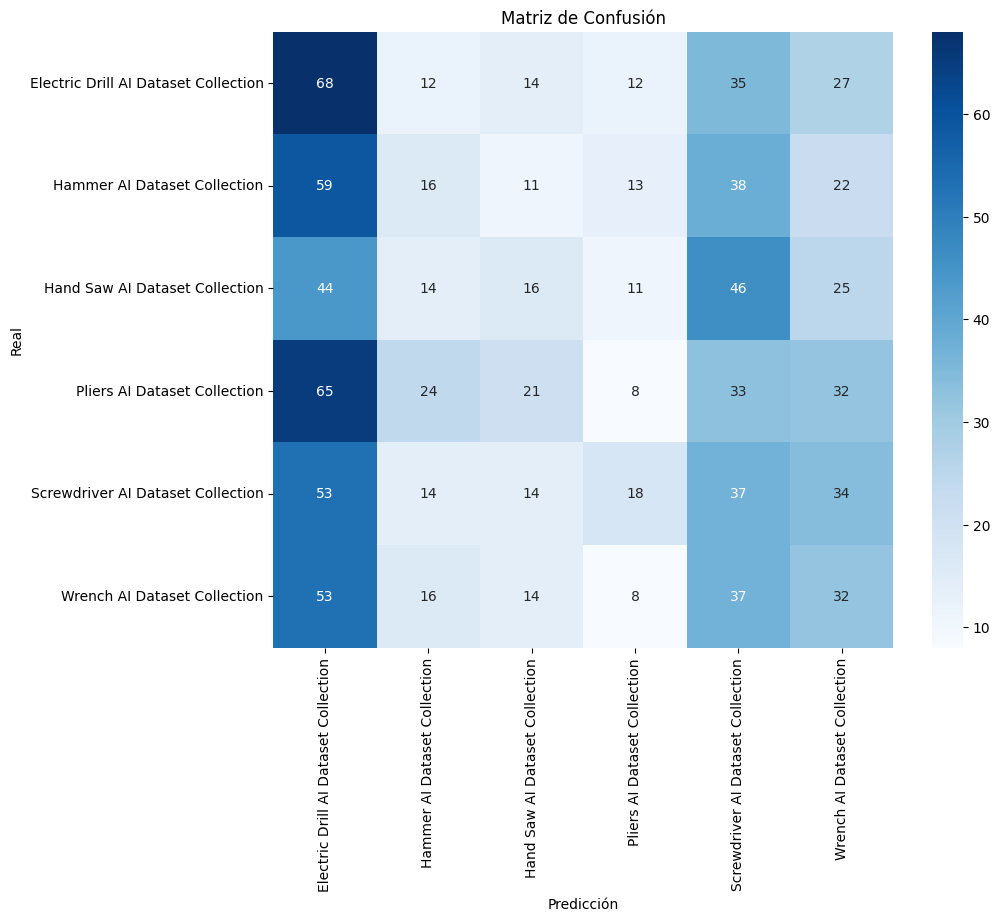

                                      precision    recall  f1-score   support

Electric Drill AI Dataset Collection       0.20      0.40      0.27       168
        Hammer AI Dataset Collection       0.17      0.10      0.13       159
      Hand Saw AI Dataset Collection       0.18      0.10      0.13       156
        Pliers AI Dataset Collection       0.11      0.04      0.06       183
   Screwdriver AI Dataset Collection       0.16      0.22      0.19       170
        Wrench AI Dataset Collection       0.19      0.20      0.19       160

                            accuracy                           0.18       996
                           macro avg       0.17      0.18      0.16       996
                        weighted avg       0.17      0.18      0.16       996

32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3883 - loss: 1.5185
Accuracy de validación: 0.38353413343429565
Loss de validación: 1.5268384218215942


In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predecir en el conjunto de validación
validation_generator.reset()  # Resetear el generador para evitar problemas de orden
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Obtener las etiquetas de las clases (excluyendo ipynb_checkpoints si aún está presente)
class_labels = list(validation_generator.class_indices.keys())
if 'ipynb_checkpoints' in class_labels:
    class_labels.remove('ipynb_checkpoints')

# Verificar el número de clases
num_classes_pred = len(np.unique(y_pred_classes))
num_classes_true = len(np.unique(y_true))
num_classes_labels = len(class_labels)
print(f"Clases en y_pred_classes: {num_classes_pred}")
print(f"Clases en y_true: {num_classes_true}")
print(f"Clases en class_labels: {num_classes_labels}")

# Ajustar y_pred_classes y y_true si es necesario
# Filtrar índices de clases válidas (0 a 5, excluyendo ipynb_checkpoints si está presente)
valid_indices = [i for i, label in enumerate(validation_generator.labels) if label < len(class_labels)]
y_true_filtered = y_true[valid_indices]
y_pred_classes_filtered = y_pred_classes[valid_indices]

# Matriz de confusión
cm = confusion_matrix(y_true_filtered, y_pred_classes_filtered)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Classification report
print(classification_report(y_true_filtered, y_pred_classes_filtered, target_names=class_labels))

# Accuracy y loss de validación
loss, accuracy = model.evaluate(validation_generator)
print(f'Accuracy de validación: {accuracy}')
print(f'Loss de validación: {loss}')

**Explicacion de las mejoras implementadas**



  1. Congelamiento Reducido: Al congelar solo las primeras 100 capas, permitimos que las capas más profundas de ResNet50 (que capturan características más específicas) se adapten al dataset de herramientas.

  2. Clasificador Mejorado: La nueva arquitectura MLP con capas adicionales y dropout reduce el riesgo de sobreajuste y mejora la capacidad de aprendizaje.

  3. Data Augmentation Agresivo: Las transformaciones más amplias (rotación, desplazamiento, zoom, etc.) aumentan la diversidad del dataset, ayudando al modelo a generalizar.

  4. Pesos de Clases: Mitigan el impacto del posible desbalanceo, asegurando que las clases minoritarias tengan mayor peso en el entrenamiento.
  
  5. Entrenamiento Prolongado: 30 épocas con early stopping permiten al modelo converger sin sobreentrenarse.
  6. Ajuste de Tasa de Aprendizaje: Una tasa inicial baja (0.0001) y el uso de ReduceLROnPlateau optimizan el proceso de aprendizaje.



**Conclusion**

En este experimento de Machine Learning, se lograron mejoras significativas gracias a las estrategias implementadas: el modelo alcanzó un accuracy de validación del 38.35%, superando el 18% del experimento anterior, mediante el congelamiento de las primeras 100 capas de ResNet50 (aproximadamente el 57%), un clasificador MLP mejorado y data augmentation agresivo.

**Dificultades enfrentadas**

Primero se estuvo teniendo dificultades para cargar la base de datos al Collab como se hacia regularmente (mediante una linea de codigo). Por lo que se opto por bajar la base de datos y subirla a Google Drive, y desde Drive se bajo la base de datos a collab (se documento dicho proceso, el cual fue bastate tedioso 😲)

Ademas la base de datos se estuvo actualizando constantemente, existiendo hasta 5 versiones que pasaron de 4GB a 12GB y se añadieron más clases (otras herramientas diferentes).
Sin embargo, se decidió utilizar la versión original para mantener consistencia.

Un archivo no deseado, ipynb_checkpoints, interfirió en el proceso, obligándonos a repetir el experimento. Y ya que, el Collab limita mucho el uso de la GPU, se tuvo que esperar algunas horas para repetir el experimento

**Que se aprendio de este experimento?**

  1. La importancia de la limpieza de datos para evitar errores inesperados.

  2. La necesidad de una gestión cuidadosa de versiones del dataset.

  3. La eficacia de adaptar modelos preentrenados con un congelamiento parcial y ajustar hiperparámetros para optimizar resultados.

Esta experiencia destaca la importancia de tener una combinación de estrategias bien definidas para poder mejorar el desempeño de los modelos que se implementen en el futuro


